### Documentation: https://geomstats.github.io/notebooks/13_real_world_applications__graph_embedding_and_clustering_in_hyperbolic_space.html

In [19]:
import logging
import matplotlib.pyplot as plt
from scipy import optimize
import geomstats.backend as gs
#import geomstats.visualization as visualization
from geomstats.datasets.utils import load_karate_graph
from geomstats.geometry.poincare_ball import PoincareBall

In [5]:
gs.random.seed(1234)
dim = 2
max_epochs = 100
lr = 0.05
n_negative = 2
context_size = 1
karate_graph = load_karate_graph()

In [6]:
nb_vertices_by_edges = [len(e_2) for _, e_2 in karate_graph.edges.items()]
logging.info("Number of vertices: %s", len(karate_graph.edges))
logging.info(
    "Mean edge-vertex ratio: %s",
    (sum(nb_vertices_by_edges, 0) / len(karate_graph.edges)),
)

INFO: Number of vertices: 34
INFO: Mean edge-vertex ratio: 4.588235294117647


In [7]:
hyperbolic_manifold = PoincareBall(2)

In [8]:
def grad_squared_distance(point_a, point_b):
    """Gradient of squared hyperbolic distance.

    Gradient of the squared distance based on the
    Ball representation according to point_a

    Parameters
    ----------
    point_a : array-like, shape=[n_samples, dim]
        First point in hyperbolic space.
    point_b : array-like, shape=[n_samples, dim]
        Second point in hyperbolic space.

    Returns
    -------
    dist : array-like, shape=[n_samples, 1]
        Geodesic squared distance between the two points.
    """
    log_map = PoincareBall(2).metric.log(point_b, point_a)

    return -2 * log_map

In [9]:
def log_sigmoid(vector):
    """Logsigmoid function.

    Apply log sigmoid function

    Parameters
    ----------
    vector : array-like, shape=[n_samples, dim]

    Returns
    -------
    result : array-like, shape=[n_samples, dim]
    """
    return gs.log((1 / (1 + gs.exp(-vector))))

In [10]:
def grad_log_sigmoid(vector):
    """Gradient of log sigmoid function.

    Parameters
    ----------
    vector : array-like, shape=[n_samples, dim]

    Returns
    -------
    gradient : array-like, shape=[n_samples, dim]
    """
    return 1 / (1 + gs.exp(vector))

In [11]:
def loss(example_embedding, context_embedding, negative_embedding, manifold):
    """Compute loss and grad.

    Compute loss and grad given embedding of the current example,
    embedding of the context and negative sampling embedding.
    """
    n_edges, dim = negative_embedding.shape[0], example_embedding.shape[-1]
    example_embedding = gs.expand_dims(example_embedding, 0)
    context_embedding = gs.expand_dims(context_embedding, 0)
    positive_distance = manifold.metric.squared_dist(
        example_embedding, context_embedding
    )
    positive_loss = log_sigmoid(-positive_distance)

    reshaped_example_embedding = gs.repeat(example_embedding, n_edges, axis=0)
    negative_distance = manifold.metric.squared_dist(
        reshaped_example_embedding, negative_embedding
    )
    negative_loss = log_sigmoid(negative_distance)

    total_loss = -(positive_loss + negative_loss.sum())

    positive_log_sigmoid_grad = -grad_log_sigmoid(-positive_distance)

    positive_distance_grad = grad_squared_distance(example_embedding, context_embedding)

    positive_grad = (
        gs.repeat(positive_log_sigmoid_grad, dim, axis=-1) * positive_distance_grad
    )

    negative_distance_grad = grad_squared_distance(
        reshaped_example_embedding, negative_embedding
    )

    negative_distance = gs.to_ndarray(negative_distance, to_ndim=2, axis=-1)
    negative_log_sigmoid_grad = grad_log_sigmoid(negative_distance)

    negative_grad = negative_log_sigmoid_grad * negative_distance_grad
    example_grad = -(positive_grad + negative_grad.sum(axis=0))

    return total_loss, example_grad

In [12]:
embeddings = gs.random.normal(size=(karate_graph.n_nodes, dim))
embeddings = embeddings * 0.2

In [13]:
random_walks = karate_graph.random_walk()

In [14]:
negative_table_parameter = 5
negative_sampling_table = []

for i, nb_v in enumerate(nb_vertices_by_edges):
    negative_sampling_table += (
        [i] * int((nb_v ** (3.0 / 4.0))) * negative_table_parameter
    )

negative_sampling_table = gs.array(negative_sampling_table)

In [16]:
for epoch in range(max_epochs):
    total_loss = []
    for path in random_walks:
        for example_index, one_path in enumerate(path):
            context_index = path[
                max(0, example_index - context_size) : min(
                    example_index + context_size, len(path)
                )
            ]
            negative_index = gs.random.randint(
                negative_sampling_table.shape[0], size=(len(context_index), n_negative)
            )
            negative_index = negative_sampling_table[negative_index]

            example_embedding = embeddings[one_path]
            for one_context_i, one_negative_i in zip(context_index, negative_index):
                context_embedding = embeddings[one_context_i]
                negative_embedding = embeddings[one_negative_i]
                total_loss_, g_ex = loss(
                    example_embedding,
                    context_embedding,
                    negative_embedding,
                    hyperbolic_manifold,
                )
                total_loss.append(total_loss_)

                example_to_update = embeddings[one_path]
                embeddings[one_path] = hyperbolic_manifold.metric.exp(
                    -lr * g_ex, example_to_update
                )
    logging.info(
        "iteration %d loss_value %f", epoch, sum(total_loss, 0) / len(total_loss)
    )

INFO: iteration 0 loss_value 1.793370
INFO: iteration 1 loss_value 1.721339
INFO: iteration 2 loss_value 1.702786
INFO: iteration 3 loss_value 1.662323
INFO: iteration 4 loss_value 1.633876
INFO: iteration 5 loss_value 1.613260
INFO: iteration 6 loss_value 1.585243
INFO: iteration 7 loss_value 1.576066
INFO: iteration 8 loss_value 1.573680
INFO: iteration 9 loss_value 1.536430
INFO: iteration 10 loss_value 1.544905
INFO: iteration 11 loss_value 1.501347
INFO: iteration 12 loss_value 1.491109
INFO: iteration 13 loss_value 1.456059
INFO: iteration 14 loss_value 1.455456
INFO: iteration 15 loss_value 1.443429
INFO: iteration 16 loss_value 1.396469
INFO: iteration 17 loss_value 1.433710
INFO: iteration 18 loss_value 1.420104
INFO: iteration 19 loss_value 1.355044
INFO: iteration 20 loss_value 1.346814
INFO: iteration 21 loss_value 1.337880
INFO: iteration 22 loss_value 1.352726
INFO: iteration 23 loss_value 1.319254
INFO: iteration 24 loss_value 1.352625
INFO: iteration 25 loss_value 1.337

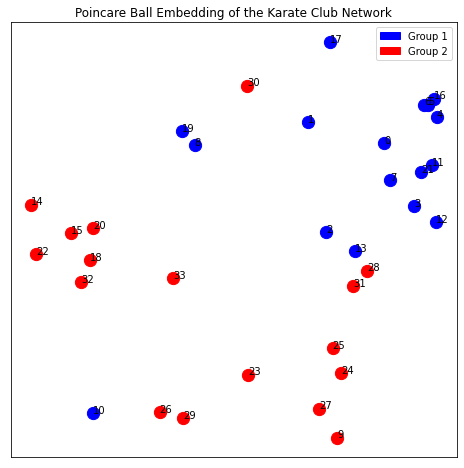

In [18]:
import matplotlib.patches as mpatches

colors = {1: "b", 2: "r"}
group_1 = mpatches.Patch(color=colors[1], label="Group 1")
group_2 = mpatches.Patch(color=colors[2], label="Group 2")

#circle = visualization.PoincareDisk(coords_type="ball")

fig, ax = plt.subplots(figsize=(8, 8))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
#circle.set_ax(ax)
#circle.draw(ax=ax)
for i_embedding, embedding in enumerate(embeddings):
    x = embedding[0]
    y = embedding[1]
    pt_id = i_embedding
    plt.scatter(x, y, c=colors[karate_graph.labels[pt_id][0]], s=150)
    ax.annotate(pt_id, (x, y))

plt.tick_params(which="both")
plt.title("Poincare Ball Embedding of the Karate Club Network")
plt.legend(handles=[group_1, group_2])
plt.show()